# Advanced Machine Learning 
## Predictive models
- Linear regression
- XGBoost

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import dump

import time
import math
import datetime

import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import itertools
from itertools import cycle

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression
import xgboost as xgb
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
import sys
sys.path.append('/Users/cent/Documents/MDSI_Spring2023/avml_at2/adv_mla_at2/src')

In [10]:
sale_train = pd.read_csv('../data/raw/sales_train.csv')
sale_test = pd.read_csv('../data/raw/sales_test.csv')
calendar = pd.read_csv('../data/raw/calendar.csv')
calendar_events = pd.read_csv('../data/raw/calendar_events.csv')
items_weekly_sell_prices = pd.read_csv('../data/raw/items_weekly_sell_prices.csv')

In [5]:
sale_train.head(5)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1532,d_1533,d_1534,d_1535,d_1536,d_1537,d_1538,d_1539,d_1540,d_1541
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,1,0,1,0,1,0,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,8,2,0,8,2,3,1,1,3,8
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,0,1,3,2,1,1,2,2,3


In [6]:
sale_test.head(5)

,d_1542,d_1543,d_1544,d_1545,d_1546,d_1547,d_1548,d_1549,d_1550,d_1551,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,0,1,0,2,1,0,2,0,1,0,...,2,4,0,0,0,0,3,3,0,1
1,0,0,0,0,0,0,0,0,1,0,...,0,1,2,1,1,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,4,1,0,1,3,5,2,3,0,2,...,1,1,0,4,0,1,3,0,2,6
4,3,0,0,1,1,0,2,0,2,1,...,0,0,0,2,1,0,0,2,1,0


In [7]:
calendar.head(5)

,date,wm_yr_wk,d
0,2011-01-29,11101,d_1
1,2011-01-30,11101,d_2
2,2011-01-31,11101,d_3
3,2011-02-01,11101,d_4
4,2011-02-02,11101,d_5


In [8]:
calendar_events.head(5)

,date,event_name,event_type
0,2011-02-06,SuperBowl,Sporting
1,2011-02-14,ValentinesDay,Cultural
2,2011-02-21,PresidentsDay,National
3,2011-03-09,LentStart,Religious
4,2011-03-16,LentWeek2,Religious


In [9]:
items_weekly_sell_prices.head(5)

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


#### Melting `sale_train`

In [11]:
sale_train_long = pd.melt(sale_train, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
    var_name='d',
    value_name='value'
)

print(sale_train_long)

                                     id        item_id    dept_id   cat_id   
0         HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES  \
1         HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
2         HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES   
3         HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES   
4         HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES   
...                                 ...            ...        ...      ...   
46985085    FOODS_3_823_WI_3_evaluation    FOODS_3_823    FOODS_3    FOODS   
46985086    FOODS_3_824_WI_3_evaluation    FOODS_3_824    FOODS_3    FOODS   
46985087    FOODS_3_825_WI_3_evaluation    FOODS_3_825    FOODS_3    FOODS   
46985088    FOODS_3_826_WI_3_evaluation    FOODS_3_826    FOODS_3    FOODS   
46985089    FOODS_3_827_WI_3_evaluation    FOODS_3_827    FOODS_3    FOODS   

         store_id state_id       d  value  
0            CA_1  

### Merge data set

In [12]:
merged_sale_calendar = pd.merge(sale_train_long, calendar, on='d', how='inner')

In [13]:
merged_sale_calendar.head(5)

,id,item_id,dept_id,cat_id,store_id,state_id,d,value,date,wm_yr_wk
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101


In [15]:
merged_sale_calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46985090 entries, 0 to 46985089
Data columns (total 10 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   id        object
 1   item_id   object
 2   dept_id   object
 3   cat_id    object
 4   store_id  object
 5   state_id  object
 6   d         object
 7   value     int64 
 8   date      object
 9   wm_yr_wk  int64 
dtypes: int64(2), object(8)
memory usage: 3.5+ GB


In [16]:
merged_calendar_event = pd.merge(merged_sale_calendar, calendar_events, on='date', how='outer')

In [17]:
merged_calendar_event.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47107087 entries, 0 to 47107086
Data columns (total 12 columns):
 #   Column      Dtype  
---  ------      -----  
 0   id          object 
 1   item_id     object 
 2   dept_id     object 
 3   cat_id      object 
 4   store_id    object 
 5   state_id    object 
 6   d           object 
 7   value       float64
 8   date        object 
 9   wm_yr_wk    float64
 10  event_name  object 
 11  event_type  object 
dtypes: float64(2), object(10)
memory usage: 4.2+ GB


In [20]:
merged_item = pd.merge(merged_calendar_event, items_weekly_sell_prices, on=['store_id','item_id','wm_yr_wk'], how='outer')

In [21]:
merged_item.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48962341 entries, 0 to 48962340
Data columns (total 13 columns):
 #   Column      Dtype  
---  ------      -----  
 0   id          object 
 1   item_id     object 
 2   dept_id     object 
 3   cat_id      object 
 4   store_id    object 
 5   state_id    object 
 6   d           object 
 7   value       float64
 8   date        object 
 9   wm_yr_wk    float64
 10  event_name  object 
 11  event_type  object 
 12  sell_price  float64
dtypes: float64(3), object(10)
memory usage: 4.7+ GB


In [22]:
merged_item.head(5)

,id,item_id,dept_id,cat_id,store_id,state_id,d,value,date,wm_yr_wk,event_name,event_type,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,2011-01-29,11101.0,NaN,NaN,NaN
1,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_2,0.0,2011-01-30,11101.0,NaN,NaN,NaN
2,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_3,0.0,2011-01-31,11101.0,NaN,NaN,NaN
3,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_4,0.0,2011-02-01,11101.0,NaN,NaN,NaN
4,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_5,0.0,2011-02-02,11101.0,NaN,NaN,NaN


In [23]:
missing_values = merged_item.isnull().sum()

print(missing_values)

id             1855291
item_id             37
dept_id        1855291
cat_id         1855291
store_id            37
state_id       1855291
d              1855291
value          1855291
date           1855254
wm_yr_wk            37
event_name    44998604
event_type    44998604
sell_price    12291913
dtype: int64


In [24]:
df_merge = merged_item.dropna(subset=['d'])

In [25]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47107050 entries, 0 to 47107049
Data columns (total 13 columns):
 #   Column      Dtype  
---  ------      -----  
 0   id          object 
 1   item_id     object 
 2   dept_id     object 
 3   cat_id      object 
 4   store_id    object 
 5   state_id    object 
 6   d           object 
 7   value       float64
 8   date        object 
 9   wm_yr_wk    float64
 10  event_name  object 
 11  event_type  object 
 12  sell_price  float64
dtypes: float64(3), object(10)
memory usage: 4.9+ GB


In [26]:
missing_values_df_merge = df_merge.isnull().sum()

print(missing_values_df_merge)

id                   0
item_id              0
dept_id              0
cat_id               0
store_id             0
state_id             0
d                    0
value                0
date                 0
wm_yr_wk             0
event_name    43143350
event_type    43143350
sell_price    12291876
dtype: int64


In [28]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47107050 entries, 0 to 47107049
Data columns (total 13 columns):
 #   Column      Dtype  
---  ------      -----  
 0   id          object 
 1   item_id     object 
 2   dept_id     object 
 3   cat_id      object 
 4   store_id    object 
 5   state_id    object 
 6   d           object 
 7   value       float64
 8   date        object 
 9   wm_yr_wk    float64
 10  event_name  object 
 11  event_type  object 
 12  sell_price  float64
dtypes: float64(3), object(10)
memory usage: 4.9+ GB


In [42]:
df_merge.shape

(47107050, 13)

In [43]:
df_merge.describe()

,value,wm_yr_wk,sell_price
count,4.710705e+07,4.710705e+07,3.481517e+07
mean,1.087059e+00,1.128854e+04,4.383812e+00
std,3.934360e+00,1.207423e+02,3.358256e+00
min,0.000000e+00,1.110100e+04,1.000000e-02
25%,0.000000e+00,1.120400e+04,2.080000e+00
50%,0.000000e+00,1.130700e+04,3.440000e+00
75%,1.000000e+00,1.140900e+04,5.840000e+00
max,7.630000e+02,1.151200e+04,1.073200e+02


## Exploratory Data Analysis

__Distribution of `item_id` Across `cat_id`__

In [29]:
# Group by 'cat_id' and count the unique 'item_id'
distribution = df_merge.groupby('cat_id')['item_id'].nunique()

print(distribution)

cat_id
FOODS        1437
HOBBIES       565
HOUSEHOLD    1047
Name: item_id, dtype: int64


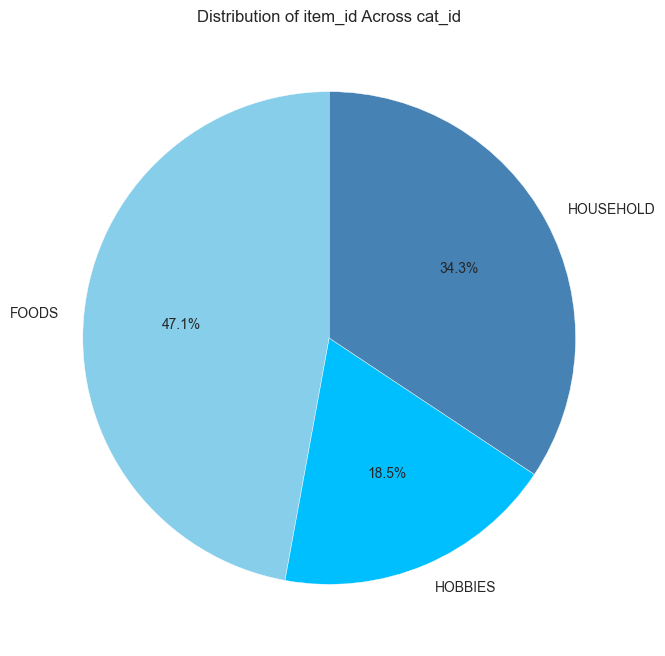

In [38]:
# Create a pie chart
plt.figure(figsize=(8, 8))
distribution.plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'deepskyblue','steelblue'], startangle=90)
plt.title('Distribution of item_id Across cat_id')
plt.ylabel('')  # Remove the y-axis label
plt.show()

From the pie chart, it can be seen that food is the most items sold, followed by household items and hobbies items.

__Distribution of total sell across state__

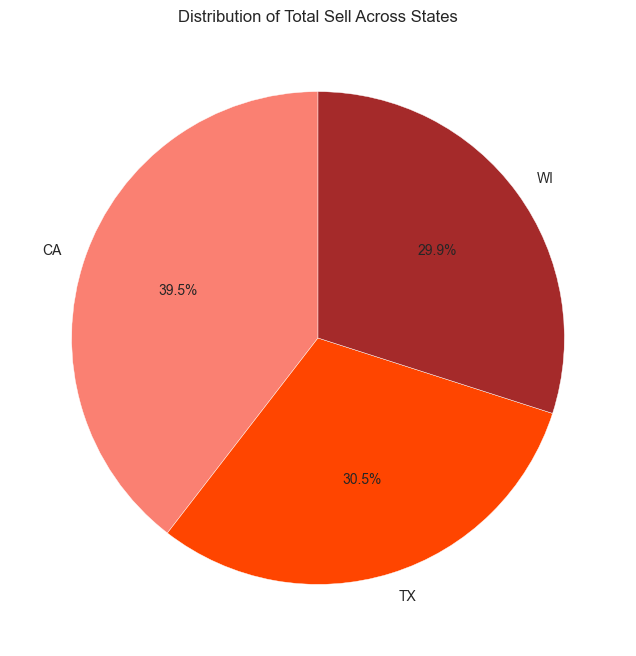

In [39]:
total_sell_per_state = df_merge.groupby('state_id')['sell_price'].sum()

plt.figure(figsize=(8, 8))
total_sell_per_state.plot(kind='pie', autopct='%1.1f%%', colors=['salmon', 'orangered','brown'], startangle=90)
plt.title('Distribution of Total Sell Across States')
plt.ylabel('')  # Remove the y-axis label
plt.show()

Regarding the total number of sales, it is once again evident that California has the largest contribution in terms of the total number of items sold, followed by Texas and Wisconsin.

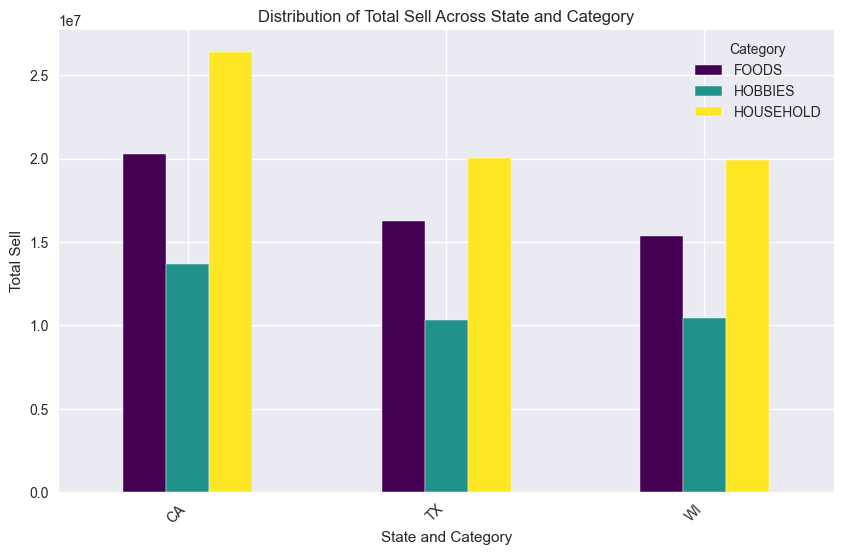

In [41]:
total_sell_per_state_cat = df_merge.groupby(['state_id', 'cat_id'])['sell_price'].sum()

# Unstack the result for multi-level indexing
total_sell_per_state_cat = total_sell_per_state_cat.unstack()

# Create a multi-level bar chart
total_sell_per_state_cat.plot(kind='bar', figsize=(10, 6), colormap='viridis')
plt.title('Distribution of Total Sell Across State and Category')
plt.xlabel('State and Category')
plt.ylabel('Total Sell')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend(title='Category')
plt.show()

California (CA) demonstrates an outstanding lead in terms of the quantity of "Total items" sold within both the FOODS and HOBBIES AND HOUSEHOLD categories. Conversely, Wisconsin (WI) closely rivals Texas (TX) in terms of the number of items sold in each category.

# 3. Pipeline

In [4]:
df = pd.read_csv('../data/raw/df_merge.csv')

/var/folders/_m/0xxz69y969n9bzj1kk4sm3c80000gn/T/ipykernel_42855/1933477398.py:1: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/raw/df_merge.csv')


In [5]:
df_cleaned = df.copy()

**[3.1]** Aggregrate revenue column

In [6]:
df_cleaned['revenue'] = df_cleaned['value'] * df_cleaned['sell_price']

In [7]:
df_cleaned['revenue_lag1'] = df_cleaned['revenue'].shift(1)  # 1 day ago
df_cleaned['revenue_lag7'] = df_cleaned['revenue'].shift(7)  # 1 week ago
df_cleaned['revenue_lag30'] = df_cleaned['revenue'].shift(30)  # 1 month ago

**[3.2]** Create Binary Indicator for Events

In [8]:
df_cleaned['has_event'] = df_cleaned['event_name'].notnull().astype(int)

**[3.3]** Convert date

In [9]:
from features.date import convert_to_date

In [10]:
convert_to_date(df_cleaned, ['date'])

,id,item_id,dept_id,cat_id,store_id,state_id,d,value,date,wm_yr_wk,event_name,event_type,sell_price,revenue,revenue_lag1,revenue_lag7,revenue_lag30,has_event
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,2011-01-29,11101.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_2,0.0,2011-01-30,11101.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_3,0.0,2011-01-31,11101.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_4,0.0,2011-02-01,11101.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_5,0.0,2011-02-02,11101.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47107045,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1541,2.0,2015-04-18,11512.0,NaN,NaN,2.88,5.76,4.28,1.40,8.94,0
47107046,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1541,0.0,2015-04-18,11512.0,NaN,NaN,2.00,0.00,5.76,0.00,5.76,0
47107047,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1541,0.0,2015-04-18,11512.0,NaN,NaN,3.98,0.00,0.00,0.00,5.96,0
47107048,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1541,0.0,2015-04-18,11512.0,NaN,NaN,1.28,0.00,0.00,0.00,0.00,0


**[3.4]** Drop columns and na values

In [11]:
# Extract day, month and year 
df_cleaned['day'] = df_cleaned['date'].dt.day
df_cleaned['month'] = df_cleaned['date'].dt.month
df_cleaned['year'] = df_cleaned['date'].dt.year

In [12]:
df_cleaned.isnull().sum()

id                      0
item_id                 0
dept_id                 0
cat_id                  0
store_id                0
state_id                0
d                       0
value                   0
date                    0
wm_yr_wk                0
event_name       43143350
event_type       43143350
sell_price       12291876
revenue          12291876
revenue_lag1     12291877
revenue_lag7     12291883
revenue_lag30    12291906
has_event               0
day                     0
month                   0
year                    0
dtype: int64

In [13]:
df_cleaned = df_cleaned.drop(['event_name', 'event_type'], axis=1)

In [14]:
df_cleaned.dropna(inplace=True)

In [15]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22473076 entries, 107 to 47107049
Data columns (total 19 columns):
 #   Column         Dtype         
---  ------         -----         
 0   id             object        
 1   item_id        object        
 2   dept_id        object        
 3   cat_id         object        
 4   store_id       object        
 5   state_id       object        
 6   d              object        
 7   value          float64       
 8   date           datetime64[ns]
 9   wm_yr_wk       float64       
 10  sell_price     float64       
 11  revenue        float64       
 12  revenue_lag1   float64       
 13  revenue_lag7   float64       
 14  revenue_lag30  float64       
 15  has_event      int64         
 16  day            int32         
 17  month          int32         
 18  year           int32         
dtypes: datetime64[ns](1), float64(7), int32(3), int64(1), object(7)
memory usage: 3.1+ GB


**[3.5]** Create pipline

In [16]:
from features.catagory_transform import MyLabelEncoder

In [17]:
# Define selected features and target
selected_features = ['value', 'item_id', 'store_id', 'year', 'month', 'day', 'revenue_lag1', 'revenue_lag7', 'has_event']
target = ['revenue']

# Split the data
X = df_cleaned[selected_features]
y = df_cleaned[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define numerical and categorical columns
num_cols = ['value', 'year', 'month', 'day', 'revenue_lag1', 'revenue_lag7', 'has_event']
cat_cols = ['item_id', 'store_id']

# Define transformers for numerical and categorical columns
num_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]
)

cat_transformer = Pipeline(
    steps=[
        ('le', MyLabelEncoder(columns=cat_cols))
    ]
)

# Create a ColumnTransformer to apply different transformers to numerical and categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ]
)

In [34]:
X_train.to_csv('../data/processed/X_train.csv', index=False)
X_test.to_csv('../data/processed/X_test.csv', index=False)
y_train.to_csv('../data/processed/y_train.csv', index=False)
y_test.to_csv('../data/processed/y_test.csv', index=False)

# Machine Learning Pipeline

## Linear Regression

**[4.1]** Create a pipeline with preprocessing and linear regression

In [29]:
lr_pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', LinearRegression())
    ]
)

**[4.3]** Train the model using the pipeline

In [30]:
lr_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['value', 'year', 'month',
                                                   'day', 'revenue_lag1',
                                                   'revenue_lag7',
                                                   'has_event']),
                                                 ('cat',
                                                  Pipeline(steps=[('le',
                                                                   MyLabelEncoder(columns=['item_id',
                                                                                           'store_id']))]),
                                                  ['item_id', 'store_id'])])),
                ('model', LinearRegression())])

**[4.4]** Make predictions on the test set

In [36]:
y_pred = lr_pipe.predict(X_test)

**[4.5]** Evaluate the model performance

In [38]:
# Evaluate the model performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f'Root Mean Squared Error (Test): {rmse}')
print(f'Mean Absolute Error (Test): {mae}')

Root Mean Squared Error (Test): 6.226024549532719
Mean Absolute Error (Test): 2.8028890575088568


**[4.6]** Joblib

In [33]:
dump(lr_pipe,  '../models/lr_pipeline.joblib')

['../models/lr_pipeline.joblib']

In [ ]:
import pickle

# Specify the file path
lr_model_path = '../models/lr_pipeline.pkl'

# Save the model
with open(lr_model_path, 'wb') as file:
    pickle.dump(lr_pipe, file)

## 4.XGBoost

In [30]:
xgb_pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', XGBRegressor(objective='reg:squarederror', random_state=42))
    ]
)

In [31]:
xgb_pipe.fit(X_train, y_train)

/Users/cent/.pyenv/versions/3.9.13/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/cent/.pyenv/versions/3.9.13/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/cent/.pyenv/versions/3.9.13/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/cent/.pyenv/versions/3.9.13/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dty

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['value', 'year', 'month',
                                                   'day', 'revenue_lag1',
                                                   'revenue_lag7',
                                                   'has_event']),
                                                 ('cat',
                                                  Pipeline(steps=[('le',
                                                                   MyLabelEncoder(columns=['item_id',
                                                                                           'store_id']))]),
                                                  ['item_id', 'store_id'])])),
                ('model',
                 XGBRegressor(bas...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [32]:
y_pred = xgb_pipe.predict(X_test)

In [33]:
# Evaluate the model performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f'Root Mean Squared Error (Test): {rmse}')
print(f'Mean Absolute Error (Test): {mae}')

Root Mean Squared Error (Test): 4.231865101732603
Mean Absolute Error (Test): 1.454795897267006


In [43]:
dump(xgb_pipe,  '../models/xgb_pipeline.joblib')

['../models/xgb_pipeline.joblib']

In [ ]:
# Specify the file path
xgb_model_path = '../models/xgb_model.pkl'

# Save the model
with open(xgb_model_path, 'wb') as file:
    pickle.dump(xgb_pipe, file)

### XGBoost wiht hyperparameter

In [18]:
xgb_para = xgb.XGBRegressor(
    objective='reg:squarederror',  # Objective function for regression
    booster='gblinear',  # Use a linear booster
    learning_rate=0.1,  # Learning rate
    n_estimators=100,  # Number of boosting rounds
    random_state=42
)

In [19]:
xgb_para_pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', xgb_para)
    ]
)

In [20]:
xgb_para_pipe.fit(X_train, y_train)

/Users/cent/.pyenv/versions/3.9.13/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/cent/.pyenv/versions/3.9.13/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['value', 'year', 'month',
                                                   'day', 'revenue_lag1',
                                                   'revenue_lag7',
                                                   'has_event']),
                                                 ('cat',
                                                  Pipeline(steps=[('le',
                                                                   MyLabelEncoder(columns=['item_id',
                                                                                           'store_id']))]),
                                                  ['item_id', 'store_id'])])),
                ('model',
                 XGBRegressor(bas...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [21]:
y_pred = xgb_para_pipe.predict(X_test)

In [22]:
# Evaluate the model performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f'Root Mean Squared Error (Test): {rmse}')
print(f'Mean Absolute Error (Test): {mae}')

Root Mean Squared Error (Test): 6.225953529619855
Mean Absolute Error (Test): 2.8037066994234285


In [23]:
dump(xgb_para_pipe,  '../models/xgb_para_pipeline.joblib')

['../models/xgb_para_pipeline.joblib']

In [ ]:
# Specify the file path
xgb_para_model_path = '../models/xgb_para_model.pkl'

# Save the model
with open(xgb_para_model_path, 'wb') as file:
    pickle.dump(xgb_para_pipe, file)

## Feature Importance

###  Xgboost Variable Importance by Permutation

In [34]:
from sklearn.base import clone

# Clone the pipeline to keep the original pipeline intact
cloned_pipeline = clone(xgb_pipe)

# Train the cloned pipeline
cloned_pipeline.fit(X_train, y_train)

# Evaluate baseline performance on validation set
y_pred_baseline = cloned_pipeline.predict(X_test)
baseline_mse = mean_squared_error(y_test, y_pred_baseline)

# Permutation Feature Importance
feature_importance = {}

for feature in X_test.columns:
    # Permute feature values
    X_test_permuted = X_test.copy()
    X_test_permuted[feature] = np.random.permutation(X_test[feature])

    # Make predictions with permuted feature
    y_test_pred_permuted = cloned_pipeline.predict(X_test_permuted)

    # Calculate performance metric (e.g., MSE)
    permuted_mse = mean_squared_error(y_test, y_test_pred_permuted)

    # Calculate importance as the drop in performance
    importance = baseline_mse - permuted_mse

    feature_importance[feature] = importance

# Sort features by importance
sorted_feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Print or visualize the feature importance
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance}")


/Users/cent/.pyenv/versions/3.9.13/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/cent/.pyenv/versions/3.9.13/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Users/cent/.pyenv/versions/3.9.13/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/cent/.pyenv/versions/3.9.13/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dty

has_event: -0.014888909148343288
day: -0.11301581002019745
month: -0.3233159932342886
revenue_lag7: -0.7148717029629239
year: -0.8984970445069109
store_id: -1.6052997592190899
revenue_lag1: -13.170909784726788
item_id: -80.52226542009
value: -145.1935125901408


## Data preparation

In [4]:
df = pd.read_csv('../data/raw/df_merge.csv')

/var/folders/_m/0xxz69y969n9bzj1kk4sm3c80000gn/T/ipykernel_69654/1933477398.py:1: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/raw/df_merge.csv')


In [5]:
df_cleaned = df.copy()

#### Find Revenue

In [6]:
df_cleaned['revenue'] = df_cleaned['value'] * df_cleaned['sell_price']

In [7]:
df_cleaned['revenue_lag1'] = df_cleaned['revenue'].shift(1)  # 1 day ago
df_cleaned['revenue_lag7'] = df_cleaned['revenue'].shift(7)  # 1 week ago
df_cleaned['revenue_lag30'] = df_cleaned['revenue'].shift(30)  # 1 month ago

#### Convert date into timestamp

In [8]:
from features.date import convert_to_date

In [10]:
convert_to_date(df_cleaned, ['date'])

,id,item_id,dept_id,cat_id,store_id,state_id,d,value,date,wm_yr_wk,event_name,event_type,sell_price,revenue,revenue_lag1,revenue_lag7,revenue_lag30
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,2011-01-29,11101.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_2,0.0,2011-01-30,11101.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_3,0.0,2011-01-31,11101.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_4,0.0,2011-02-01,11101.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_5,0.0,2011-02-02,11101.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47107045,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1541,2.0,2015-04-18,11512.0,NaN,NaN,2.88,5.76,4.28,1.40,8.94
47107046,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1541,0.0,2015-04-18,11512.0,NaN,NaN,2.00,0.00,5.76,0.00,5.76
47107047,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1541,0.0,2015-04-18,11512.0,NaN,NaN,3.98,0.00,0.00,0.00,5.96
47107048,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1541,0.0,2015-04-18,11512.0,NaN,NaN,1.28,0.00,0.00,0.00,0.00


In [11]:
# Convert timestamp column to datetime type
# df_cleaned['date'] = pd.to_datetime(df_cleaned['date'], utc=True)

# Extract day, month and year 
df_cleaned['day'] = df_cleaned['date'].dt.day
df_cleaned['month'] = df_cleaned['date'].dt.month
df_cleaned['year'] = df_cleaned['date'].dt.year

#### Label encoded

In [12]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
for column in ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']:
    df_cleaned[column + '_encoded'] = label_encoder.fit_transform(df_cleaned[column])

#### Create Binary Indicator for Events

In [13]:
df_cleaned['has_event'] = df_cleaned['event_name'].notnull().astype(int)

In [14]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47107050 entries, 0 to 47107049
Data columns (total 26 columns):
 #   Column            Dtype         
---  ------            -----         
 0   id                object        
 1   item_id           object        
 2   dept_id           object        
 3   cat_id            object        
 4   store_id          object        
 5   state_id          object        
 6   d                 object        
 7   value             float64       
 8   date              datetime64[ns]
 9   wm_yr_wk          float64       
 10  event_name        object        
 11  event_type        object        
 12  sell_price        float64       
 13  revenue           float64       
 14  revenue_lag1      float64       
 15  revenue_lag7      float64       
 16  revenue_lag30     float64       
 17  day               int64         
 18  month             int64         
 19  year              int64         
 20  item_id_encoded   int64         
 21  dept_i

In [15]:
df_cleaned.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'value', 'date', 'wm_yr_wk', 'event_name', 'event_type', 'sell_price',
       'revenue', 'revenue_lag1', 'revenue_lag7', 'revenue_lag30', 'day',
       'month', 'year', 'item_id_encoded', 'dept_id_encoded', 'cat_id_encoded',
       'store_id_encoded', 'state_id_encoded', 'has_event'],
      dtype='object')

In [16]:
selected_columns = ['date','value', 'sell_price', 'month', 'year', 'day', 'has_event',
                    'revenue_lag1', 'revenue_lag7','revenue_lag30', 'item_id_encoded',
                    'dept_id_encoded', 'cat_id_encoded', 'store_id_encoded',
                    'state_id_encoded', 'revenue']

# Create a new DataFrame with only the selected columns
df_selected = df_cleaned[selected_columns]

# Save the new DataFrame to a CSV file
df_selected.to_csv('../data/processed/cleaned_data_selected_cols.csv', index=False)

## Correlation

In [5]:
df_selected = pd.read_csv('../data/processed/cleaned_data_selected_cols.csv')

In [6]:
# Display the correlation of each feature with the target variable 'revenue'
cor_with_revenue = df_selected[['date','value', 'sell_price', 'month', 'year', 'day', 'has_event',
                    'revenue_lag1', 'revenue_lag7','revenue_lag30', 'item_id_encoded',
                    'dept_id_encoded', 'cat_id_encoded', 'store_id_encoded',
                    'state_id_encoded', 'revenue']].corr()['revenue'].sort_values(ascending=False)

print(cor_with_revenue)

revenue             1.000000
value               0.727198
revenue_lag1        0.608390
sell_price          0.069520
revenue_lag7        0.066027
revenue_lag30       0.045197
has_event          -0.004132
month              -0.004871
day                -0.020959
year               -0.035306
state_id_encoded   -0.043995
store_id_encoded   -0.044663
dept_id_encoded    -0.074452
item_id_encoded    -0.075178
cat_id_encoded     -0.078661
Name: revenue, dtype: float64


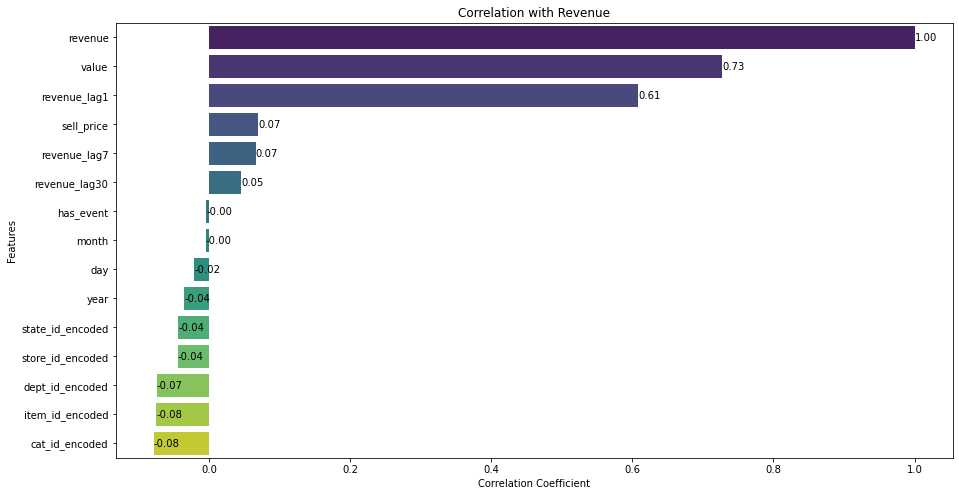

In [7]:
# Plotting
plt.figure(figsize=(15, 8))

# Use a Seaborn color palette with the correct format
colors = sns.color_palette('viridis', n_colors=len(cor_with_revenue))

sns.barplot(x=cor_with_revenue.values, y=cor_with_revenue.index, palette=colors)

# Annotate each bar with its value
for index, value in enumerate(cor_with_revenue.values):
    plt.text(value, index, f'{value:.2f}', ha='left', va='center', color='black')

plt.title('Correlation with Revenue')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()